In [ ]:
# add lags for consumption and transfer flows of previous & DA lag 2x

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import plotly
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
from datetime import date, datetime
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#confirm this works
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [86]:
lmp_data_tot = pd.read_csv('data/processed/price_data.csv')
lmp_data_tot['datetime_beginning_utc'] = pd.to_datetime(lmp_data_tot['datetime_beginning_utc'])
lmp_data_tot['datetime_beginning_ept'] = pd.to_datetime(lmp_data_tot['datetime_beginning_ept'])

In [87]:
# removing the last 8 days of data for use in modeling,
# but retaining the total data for lag variable creation
lmp_data = lmp_data_tot.loc[lmp_data_tot['datetime_beginning_ept'] >= pd.Timestamp(2016, 1, 1)].copy()

In [4]:
lmp_data.head()

datetime_beginning_utc datetime_beginning_ept  total_lmp_rt  \
192    2016-01-01 05:00:00    2016-01-01 00:00:00     19.603853   
193    2016-01-01 06:00:00    2016-01-01 01:00:00     16.727400   
194    2016-01-01 07:00:00    2016-01-01 02:00:00     14.526689   
195    2016-01-01 08:00:00    2016-01-01 03:00:00     15.547734   
196    2016-01-01 09:00:00    2016-01-01 04:00:00     16.736856   

     system_energy_price_rt  congestion_price_rt  marginal_loss_price_rt  \
192                   19.36             0.040000                0.203853   
193                   16.44             0.020000                0.267400   
194                   14.21             0.070000                0.246689   
195                   14.57             0.730859                0.246876   
196                   15.10             1.386733                0.250123   

     total_lmp_da  system_energy_price_da  congestion_price_da  \
192     20.996471                   20.32             0.703161   
193     20.104409                   19.28             0.857021   
194     17.944640                   17.07             0.889730   
195     17.757075                   16.89             0.890868   
196     18.446066                   17.37             1.062460   

     marginal_loss_price_da  pepco_mw  apsouth_flow_mw  apsouth_spread_mw  \
192               -0.026690  2351.764           1838.0             1162.0   
193               -0.032612  2325.194           2325.0              675.0   
194               -0.015090  2269.001           2345.0              655.0   
195               -0.023793  2273.126           2441.0              559.0   
196                0.013606  2243.840           2513.0              487.0   

     bcpep_flow_mw  bcpep_spread_mw  bed_bla_flow_mw  bed_bla_spread_mw  \
192         3784.0           2316.0            676.0              624.0   
193         3464.0           2636.0            746.0              554.0   
194         3494.0           2606.0            810.0              490.0   
195         3554.0           2546.0            960.0              340.0   
196         3583.0           2517.0            982.0              318.0   

     central_flow_mw  central_spread_mw  east_flow_mw  east_spread_mw  \
192           -388.0             3388.0        1815.0          3385.0   
193           -633.0             3633.0        1646.0          3554.0   
194           -776.0             3776.0        1469.0          3731.0   
195           -907.0             3907.0        1305.0          3895.0   
196           -977.0             3977.0        1348.0          3852.0   

     west_flow_mw  west_spread_mw  maintenance_outages_mw  forced_outages_mw  \
192        1168.0          2632.0                  2245.0              622.0   
193         845.0          2955.0                  2245.0              622.0   
194         813.0          2987.0                  2245.0              622.0   
195         789.0          3011.0                  2245.0              622.0   
196         831.0          2969.0                  2245.0              622.0   

     dewPoint   enthalpy  apparentTemperature    DD  CDD   HDD  uvIndex  \
192     33.72  14.825099                43.70  0.89  0.0  0.89      0.0   
193     33.55  14.644858                43.07  0.91  0.0  0.91      0.0   
194     33.04  14.327407                42.12  0.95  0.0  0.95      0.0   
195     32.49  14.103221                41.58  0.98  0.0  0.98      0.0   
196     31.86  13.897814                41.17  0.99  0.0  0.99      0.0   

     peak_hour  humidity  humidity_ratio  
192          0      0.68        0.004014  
193          0      0.69        0.003988  
194          0      0.70        0.003907  
195          0      0.70        0.003820  
196          0      0.69        0.003722

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def print_metrics(y_true, y_pred):
    """
    prints mean squared error, mean absolute error and mean absolute percentage error
    """
    print('MSE: ', round(mean_squared_error(y_true, y_pred),2))
    print('MAE: ', round(mean_absolute_error(y_true, y_pred),2))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, y_pred),2),'%')  

In [7]:
def init_prophet_model(regressors=[], holidays=False, model=Prophet()):
    """
    initializes a prophet model.
    adds regressors from a list of column names to be used as regressors.
    includes holidays if holidays=True
    """
    m = model
    if len(regressors) > 0:
        for reg in regressors:
            m.add_regressor(reg)
    if holidays == True:
        m.add_country_holidays(country_name='US')
    return m

In [8]:
def prophet_df(df, time, target, regressors=[]):
    """
    prepares dataframe for use with prophet based on
    specified time series, target and regressors
    """
    df_prep = df.copy()
    df_prep.rename(columns={time: 'ds', target: 'y'}, inplace=True)
    df_prep = df_prep[['ds', 'y']+regressors]
    return df_prep

# baseline no regressors

In [27]:
# initializing baseline model
m_lmp = init_prophet_model()

In [28]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt')
pred_lmp = df_lmp.drop(columns=['y']).copy()

In [29]:
# fitting the baseline model
m_lmp.fit(df_lmp);

In [30]:
fcst_lmp = m_lmp.predict(pred_lmp)

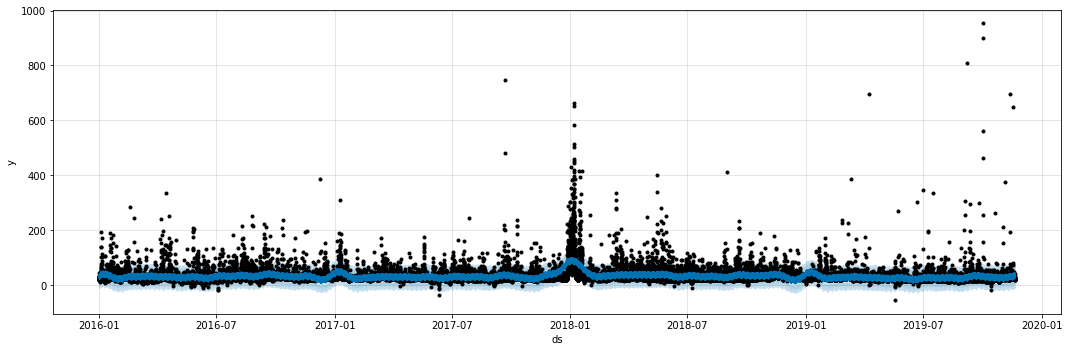

In [31]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp.plot(fcst_lmp, ax=ax)

In [32]:
fig = m_lmp.plot_components(fcst_lmp)

In [33]:
compare_lmp = fcst_lmp.set_index('ds')[['yhat',
                                        'yhat_lower',
                                        'yhat_upper']].join(df_lmp.set_index('ds'))

In [34]:
print_metrics(compare_lmp['y'], compare_lmp['yhat'])

MSE:  657.11
MAE:  11.12
MAPE:  34.29 %


# baseline with regressors

In [35]:
# creating list of all possible regressors for use as baseline model
lmp_base_reg = list(lmp_data.iloc[:,6:].columns)

In [36]:
# initializing baseline model
m_lmp_base = init_prophet_model(lmp_base_reg)

In [37]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_base = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_base_reg)
pred_lmp_base = df_lmp_base.drop(columns=['y']).copy()

In [38]:
# fitting the baseline model
m_lmp_base.fit(df_lmp_base);

In [39]:
fcst_lmp_base = m_lmp_base.predict(pred_lmp_base)

In [40]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_base.plot(fcst_lmp_base, ax=ax)

In [41]:
fig = m_lmp_base.plot_components(fcst_lmp_base)

In [42]:
compare_lmp_base = fcst_lmp_base.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_base.set_index('ds'))

In [43]:
print_metrics(compare_lmp_base['y'], compare_lmp_base['yhat'])

MSE:  434.86
MAE:  7.65
MAPE:  21.04 %


# with scaling of regressors

In [20]:
# creating list of all possible regressors for use as baseline model
lmp_base_reg = list(lmp_data.iloc[:,6:].columns)

In [21]:
# initializing baseline model
m_lmp_std = init_prophet_model(lmp_base_reg)

In [22]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_std = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_base_reg)

In [23]:
# scaling the regressors
std_scaler_lmp = StandardScaler()
std_reg_lmp = std_scaler_lmp.fit_transform(df_lmp_std[lmp_base_reg])
df_lmp_std[lmp_base_reg] = std_reg_lmp

In [36]:
pred_lmp_std = df_lmp_std.drop(columns=['y']).copy()

In [25]:
# fitting the baseline model
m_lmp_std.fit(df_lmp_std);

In [37]:
fcst_lmp_std = m_lmp_std.predict(pred_lmp_std)

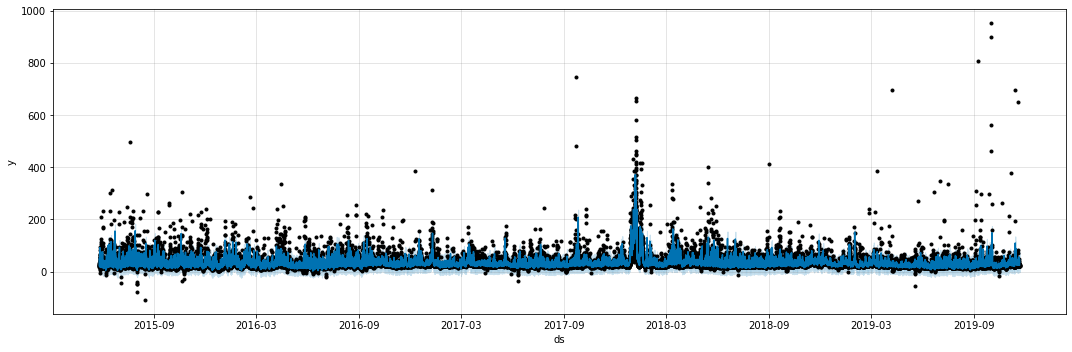

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m_lmp_std.plot(fcst_lmp_std, ax=ax)

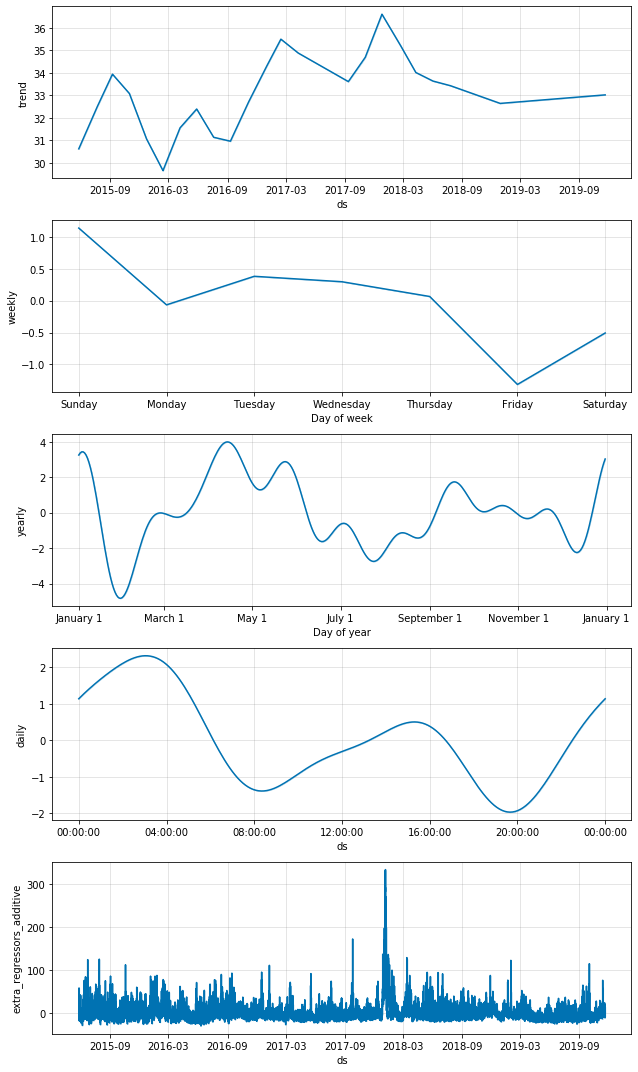

In [39]:
fig = m_lmp_std.plot_components(fcst_lmp_std)

In [40]:
compare_lmp_std = fcst_lmp_std.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_std.set_index('ds'))

In [41]:
print_metrics(compare_lmp_std['y'], compare_lmp_std['yhat'])

MSE:  442.75
MAE:  7.96
MAPE:  21.85 %


# Feature Engineering

In [9]:
lmp_data.head()

datetime_beginning_utc datetime_beginning_ept  total_lmp_rt  \
192    2016-01-01 05:00:00    2016-01-01 00:00:00     19.603853   
193    2016-01-01 06:00:00    2016-01-01 01:00:00     16.727400   
194    2016-01-01 07:00:00    2016-01-01 02:00:00     14.526689   
195    2016-01-01 08:00:00    2016-01-01 03:00:00     15.547734   
196    2016-01-01 09:00:00    2016-01-01 04:00:00     16.736856   

     system_energy_price_rt  congestion_price_rt  marginal_loss_price_rt  \
192                   19.36             0.040000                0.203853   
193                   16.44             0.020000                0.267400   
194                   14.21             0.070000                0.246689   
195                   14.57             0.730859                0.246876   
196                   15.10             1.386733                0.250123   

     total_lmp_da  system_energy_price_da  congestion_price_da  \
192     20.996471                   20.32             0.703161   
193     20.104409                   19.28             0.857021   
194     17.944640                   17.07             0.889730   
195     17.757075                   16.89             0.890868   
196     18.446066                   17.37             1.062460   

     marginal_loss_price_da  pepco_mw  apsouth_flow_mw  apsouth_spread_mw  \
192               -0.026690  2351.764           1838.0             1162.0   
193               -0.032612  2325.194           2325.0              675.0   
194               -0.015090  2269.001           2345.0              655.0   
195               -0.023793  2273.126           2441.0              559.0   
196                0.013606  2243.840           2513.0              487.0   

     bcpep_flow_mw  bcpep_spread_mw  bed_bla_flow_mw  bed_bla_spread_mw  \
192         3784.0           2316.0            676.0              624.0   
193         3464.0           2636.0            746.0              554.0   
194         3494.0           2606.0            810.0              490.0   
195         3554.0           2546.0            960.0              340.0   
196         3583.0           2517.0            982.0              318.0   

     central_flow_mw  central_spread_mw  east_flow_mw  east_spread_mw  \
192           -388.0             3388.0        1815.0          3385.0   
193           -633.0             3633.0        1646.0          3554.0   
194           -776.0             3776.0        1469.0          3731.0   
195           -907.0             3907.0        1305.0          3895.0   
196           -977.0             3977.0        1348.0          3852.0   

     west_flow_mw  west_spread_mw  maintenance_outages_mw  forced_outages_mw  \
192        1168.0          2632.0                  2245.0              622.0   
193         845.0          2955.0                  2245.0              622.0   
194         813.0          2987.0                  2245.0              622.0   
195         789.0          3011.0                  2245.0              622.0   
196         831.0          2969.0                  2245.0              622.0   

     dewPoint   enthalpy  apparentTemperature    DD  CDD   HDD  uvIndex  \
192     33.72  14.825099                43.70  0.89  0.0  0.89      0.0   
193     33.55  14.644858                43.07  0.91  0.0  0.91      0.0   
194     33.04  14.327407                42.12  0.95  0.0  0.95      0.0   
195     32.49  14.103221                41.58  0.98  0.0  0.98      0.0   
196     31.86  13.897814                41.17  0.99  0.0  0.99      0.0   

     peak_hour  humidity  humidity_ratio  
192          0      0.68        0.004014  
193          0      0.69        0.003988  
194          0      0.70        0.003907  
195          0      0.70        0.003820  
196          0      0.69        0.003722

In [88]:
# Feature Engineering
# inverting since a lower value should correspond to higher price
# lmp_data['inv_bcpep_spread_mw'] = lmp_data['bcpep_spread_mw'].apply(lambda x: 1 if x == 0 else 1/x)

# define function to create interactions and polynomials

lmp_data['pepco_mw_2'] = lmp_data['pepco_mw'] * lmp_data['pepco_mw']
lmp_data['pepco_mw_HDD'] = lmp_data['pepco_mw'] * lmp_data['HDD']
lmp_data['pepco_mw_CDD'] = lmp_data['pepco_mw'] * lmp_data['CDD']
lmp_data['pepco_mw_DD'] = lmp_data['pepco_mw'] * lmp_data['DD']
lmp_data['sys_energy_congest_da'] = lmp_data['system_energy_price_da'] * lmp_data['congestion_price_da']
lmp_data['sys_energy_marginal_da'] = lmp_data['system_energy_price_da'] * lmp_data['marginal_loss_price_da']
lmp_data['marginal_congest_da'] = lmp_data['marginal_loss_price_da'] * lmp_data['congestion_price_da']
lmp_data['sys_energy_da_2'] = lmp_data['system_energy_price_da'] * lmp_data['system_energy_price_da']
lmp_data['congestion_da_2'] = lmp_data['congestion_price_da'] * lmp_data['congestion_price_da']
lmp_data['marginal_da_2'] = lmp_data['marginal_loss_price_da'] * lmp_data['marginal_loss_price_da']

lmp_data_tot['sys_energy_congest_da'] = lmp_data_tot['system_energy_price_da'] * lmp_data_tot['congestion_price_da']
lmp_data_tot['sys_energy_marginal_da'] = lmp_data_tot['system_energy_price_da'] * lmp_data_tot['marginal_loss_price_da']
lmp_data_tot['marginal_congest_da'] = lmp_data_tot['marginal_loss_price_da'] * lmp_data_tot['congestion_price_da']
lmp_data_tot['sys_energy_da_2'] = lmp_data_tot['system_energy_price_da'] * lmp_data_tot['system_energy_price_da']
lmp_data_tot['congestion_da_2'] = lmp_data_tot['congestion_price_da'] * lmp_data_tot['congestion_price_da']
lmp_data_tot['marginal_da_2'] = lmp_data_tot['marginal_loss_price_da'] * lmp_data_tot['marginal_loss_price_da']

In [89]:
# Generating lag variables for the last 6 hours and the previous day's value
# if the 1-hour lag is retained the model can only predict one hour ahead,
# otherwise you wouldn't have that variable to use in the prediction
# this generalizes to the smallest x for which x-hour lag is retained
cols_to_lag = ['system_energy_price_rt', 'congestion_price_rt', 'marginal_loss_price_rt',
               'system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
               'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
               'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'pepco_mw',
               'bcpep_flow_mw', 'bcpep_spread_mw']
lmp_data_lag = lmp_data_tot[['datetime_beginning_ept']].copy()
for i in [1, 2, 3, 4, 5, 6, 24, 25, 26, 27]:
    for col in cols_to_lag:
        lmp_data_lag[col+'_lag_{}'.format(i)] = lmp_data_tot[col].shift(i)
lmp_data = lmp_data.merge(lmp_data_lag,
                          how='left',
                          left_on='datetime_beginning_ept',
                          right_on='datetime_beginning_ept')

In [90]:
lmp_data['sys_energy_congest_rt_lag_1'] = lmp_data['system_energy_price_rt_lag_1'] * lmp_data['congestion_price_rt_lag_1']
lmp_data['sys_energy_marginal_rt_lag_1'] = lmp_data['system_energy_price_rt_lag_1'] * lmp_data['marginal_loss_price_rt_lag_1']
lmp_data['marginal_congest_rt_lag_1'] = lmp_data['marginal_loss_price_rt_lag_1'] * lmp_data['congestion_price_rt_lag_1']
lmp_data['sys_energy_rt_2_lag_1'] = lmp_data['system_energy_price_rt_lag_1'] * lmp_data['system_energy_price_rt_lag_1']
lmp_data['congestion_rt_2_lag_1'] = lmp_data['congestion_price_rt_lag_1'] * lmp_data['congestion_price_rt_lag_1']
lmp_data['marginal_rt_2_lag_1'] = lmp_data['marginal_loss_price_rt_lag_1'] * lmp_data['marginal_loss_price_rt_lag_1']

In [91]:
lmp_data['sys_energy_congest_rt_lag_2'] = lmp_data['system_energy_price_rt_lag_2'] * lmp_data['congestion_price_rt_lag_2']
lmp_data['sys_energy_marginal_rt_lag_2'] = lmp_data['system_energy_price_rt_lag_2'] * lmp_data['marginal_loss_price_rt_lag_2']
lmp_data['marginal_congest_rt_lag_2'] = lmp_data['marginal_loss_price_rt_lag_2'] * lmp_data['congestion_price_rt_lag_2']
lmp_data['sys_energy_rt_2_lag_2'] = lmp_data['system_energy_price_rt_lag_2'] * lmp_data['system_energy_price_rt_lag_2']
lmp_data['congestion_rt_2_lag_2'] = lmp_data['congestion_price_rt_lag_2'] * lmp_data['congestion_price_rt_lag_2']
lmp_data['marginal_rt_2_lag_2'] = lmp_data['marginal_loss_price_rt_lag_2'] * lmp_data['marginal_loss_price_rt_lag_2']

In [92]:
lmp_data['sys_energy_congest_rt_lag_24'] = lmp_data['system_energy_price_rt_lag_24'] * lmp_data['congestion_price_rt_lag_24']
lmp_data['sys_energy_marginal_rt_lag_24'] = lmp_data['system_energy_price_rt_lag_24'] * lmp_data['marginal_loss_price_rt_lag_24']
lmp_data['marginal_congest_rt_lag_24'] = lmp_data['marginal_loss_price_rt_lag_24'] * lmp_data['congestion_price_rt_lag_24']
lmp_data['sys_energy_rt_2_lag_24'] = lmp_data['system_energy_price_rt_lag_24'] * lmp_data['system_energy_price_rt_lag_24']
lmp_data['congestion_rt_2_lag_24'] = lmp_data['congestion_price_rt_lag_24'] * lmp_data['congestion_price_rt_lag_24']
lmp_data['marginal_rt_2_lag_24'] = lmp_data['marginal_loss_price_rt_lag_24'] * lmp_data['marginal_loss_price_rt_lag_24']

In [93]:
lmp_data['sys_energy_congest_rt_lag_25'] = lmp_data['system_energy_price_rt_lag_25'] * lmp_data['congestion_price_rt_lag_25']
lmp_data['sys_energy_marginal_rt_lag_25'] = lmp_data['system_energy_price_rt_lag_25'] * lmp_data['marginal_loss_price_rt_lag_25']
lmp_data['marginal_congest_rt_lag_25'] = lmp_data['marginal_loss_price_rt_lag_25'] * lmp_data['congestion_price_rt_lag_25']
lmp_data['sys_energy_rt_2_lag_25'] = lmp_data['system_energy_price_rt_lag_25'] * lmp_data['system_energy_price_rt_lag_25']
lmp_data['congestion_rt_2_lag_25'] = lmp_data['congestion_price_rt_lag_25'] * lmp_data['congestion_price_rt_lag_25']
lmp_data['marginal_rt_2_lag_25'] = lmp_data['marginal_loss_price_rt_lag_25'] * lmp_data['marginal_loss_price_rt_lag_25']

# with transformations too

In [94]:
list(lmp_data.iloc[:,6:].columns)

['total_lmp_da',
 'system_energy_price_da',
 'congestion_price_da',
 'marginal_loss_price_da',
 'pepco_mw',
 'apsouth_flow_mw',
 'apsouth_spread_mw',
 'bcpep_flow_mw',
 'bcpep_spread_mw',
 'bed_bla_flow_mw',
 'bed_bla_spread_mw',
 'central_flow_mw',
 'central_spread_mw',
 'east_flow_mw',
 'east_spread_mw',
 'west_flow_mw',
 'west_spread_mw',
 'maintenance_outages_mw',
 'forced_outages_mw',
 'dewPoint',
 'enthalpy',
 'apparentTemperature',
 'DD',
 'CDD',
 'HDD',
 'uvIndex',
 'peak_hour',
 'humidity',
 'humidity_ratio',
 'pepco_mw_2',
 'pepco_mw_HDD',
 'pepco_mw_CDD',
 'pepco_mw_DD',
 'sys_energy_congest_da',
 'sys_energy_marginal_da',
 'marginal_congest_da',
 'sys_energy_da_2',
 'congestion_da_2',
 'marginal_da_2',
 'system_energy_price_rt_lag_1',
 'congestion_price_rt_lag_1',
 'marginal_loss_price_rt_lag_1',
 'system_energy_price_da_lag_1',
 'congestion_price_da_lag_1',
 'marginal_loss_price_da_lag_1',
 'sys_energy_congest_da_lag_1',
 'sys_energy_marginal_da_lag_1',
 'marginal_congest_

In [96]:
# creating list of all possible regressors for use as baseline model
# lmp_base_reg = list(lmp_data.iloc[:, 6:].columns)
# lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
#                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
#                'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
#                'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
# lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
#                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
#                'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
#                'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
#                'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
#                'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
#                'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
#                'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
#                'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
#                'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
#                'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
#                'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27']

lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                          'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                          'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                          'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                          'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                          'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                          'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                          'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                          'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                          'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                          'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                          'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                          'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                          'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                          'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                          'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                          'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                          'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                          'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                          'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                          'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                          'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                          'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                          'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
              'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

In [97]:
# initializing baseline model
m_lmp_trans = init_prophet_model(lmp_sel_reg, model=Prophet(seasonality_prior_scale=0.2))

In [98]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_trans = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_sel_reg)

In [99]:
# scaling the regressors
# std_scaler_lmp_trans = StandardScaler()
# std_reg_lmp_trans = std_scaler_lmp_trans.fit_transform(df_lmp_trans[lmp_sel_reg])
# df_lmp_trans[lmp_sel_reg] = std_reg_lmp_trans

In [100]:
# This lowered performance by ~1% by seemingly consistently reducing the predictions
# yj_lmp_reg = PowerTransformer(method='yeo-johnson')

# orig_lmp_reg = df_lmp_trans[lmp_sel_reg].copy()
# pre_trans_lmp_reg = np.array(orig_lmp_reg)
# # .reshape(-1, 1)
# transformed_reg = yj_lmp_reg.fit_transform(pre_trans_lmp_reg)
# df_lmp_trans[lmp_sel_reg] = transformed_reg

In [101]:
yj_lmp = PowerTransformer(method='yeo-johnson')

orig_lmp_y = df_lmp_trans['y'].copy()
pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
df_lmp_trans['y'] = transformed_y

In [102]:
pred_lmp_trans = df_lmp_trans.drop(columns=['y']).copy()

In [103]:
# fitting the baseline model
m_lmp_trans.fit(df_lmp_trans);

In [104]:
fcst_lmp_trans = m_lmp_trans.predict(pred_lmp_trans)

In [105]:
# inverse transforming the y's
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_trans[column] = yj_lmp.inverse_transform(np.array(fcst_lmp_trans[column]).reshape(-1, 1))
m_lmp_trans.history['y'] = yj_lmp.inverse_transform(np.array(m_lmp_trans.history['y']).reshape(-1, 1))
df_lmp_trans['y'] = orig_lmp_y

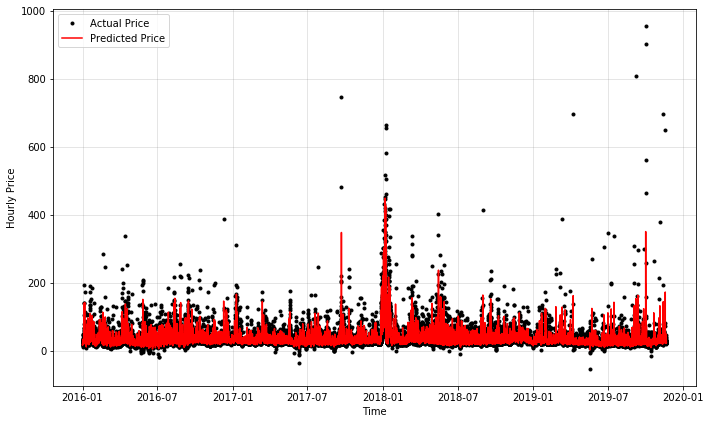

In [106]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig = m_lmp_trans.plot(fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=False, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();
plt.savefig('img/Predictions.png');
# ax.fill_between(fcst_lmp_trans['ds'], fcst_lmp_trans['yhat_lower'], fcst_lmp_trans['yhat_upper'], color='yellow', alpha=0.5)
# fig = plot_plotly(m_lmp_trans, fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=True)
# py.iplot(fig)

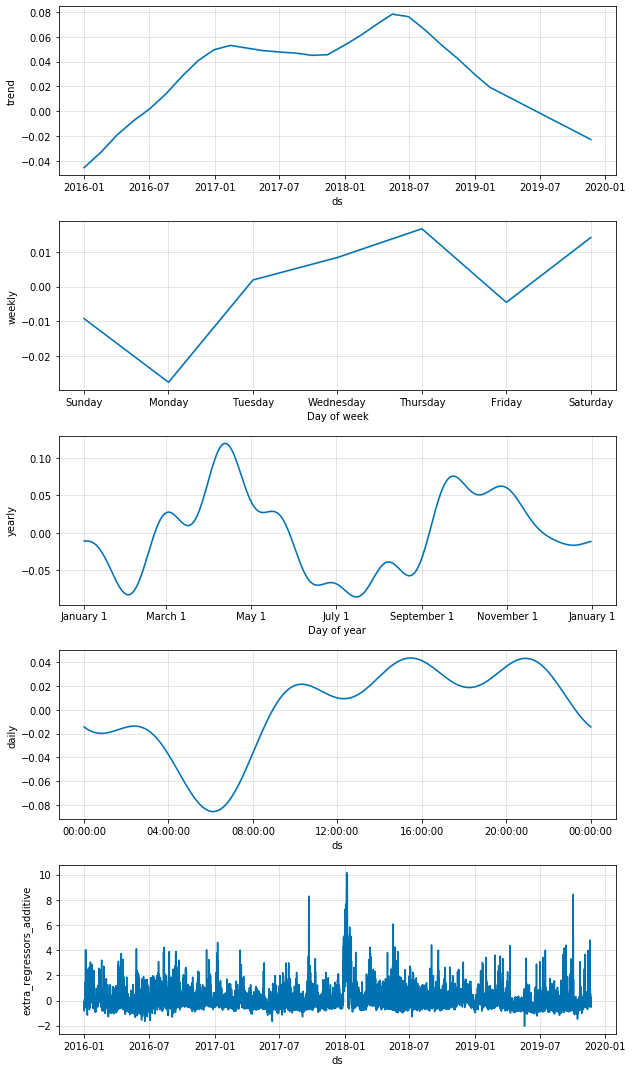

In [107]:
fig = m_lmp_trans.plot_components(fcst_lmp_trans)

In [108]:
compare_lmp_trans = fcst_lmp_trans.set_index('ds')[['yhat',
                                                    'yhat_lower',
                                                    'yhat_upper']].join(df_lmp_trans.set_index('ds'))

In [109]:
print_metrics(compare_lmp_trans['y'], compare_lmp_trans['yhat'])

MSE:  343.91
MAE:  6.1
MAPE:  15.72 %


In [357]:
print_metrics(compare_lmp_trans['y'], compare_lmp_trans['yhat'])

MSE:  429.89
MAE:  7.04
MAPE:  18.42 %


In [157]:
compare_lmp_trans['da_yhat'] = (compare_lmp_trans['system_energy_price_da']
                                + compare_lmp_trans['congestion_price_da']
                                + compare_lmp_trans['marginal_loss_price_da'])

In [158]:
print_metrics(compare_lmp_trans['y'], compare_lmp_trans['da_yhat'])

MSE:  443.47
MAE:  7.57
MAPE:  20.51 %


# 2nd Hour Prediction

In [110]:
# creating list of all possible regressors for use as baseline model
# lmp_base_reg = list(lmp_data.iloc[:, 6:].columns)
# lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
#                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
#                'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
#                'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
# lmp_sel_reg_2 = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
#                  'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
#                  'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
#                  'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
#                  'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
#                  'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
#                  'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
#                  'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
#                  'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
#                  'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
#                  'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27']

lmp_sel_reg_2 = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                          'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                          'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                          'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                          'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                          'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                          'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                          'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                          'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                          'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                          'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                          'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                          'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                          'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                          'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                          'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                          'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                          'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                          'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                          'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                          'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
                'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

In [111]:
# initializing baseline model
m_lmp_trans_2 = init_prophet_model(lmp_sel_reg_2, model=Prophet(seasonality_prior_scale=0.2))

In [112]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_trans_2 = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', lmp_sel_reg_2)

In [113]:
# scaling the regressors
# std_scaler_lmp_trans = StandardScaler()
# std_reg_lmp_trans = std_scaler_lmp_trans.fit_transform(df_lmp_trans[lmp_sel_reg])
# df_lmp_trans[lmp_sel_reg] = std_reg_lmp_trans

In [114]:
# This lowered performance by ~1% by seemingly consistently reducing the predictions
# yj_lmp_reg = PowerTransformer(method='yeo-johnson')

# orig_lmp_reg = df_lmp_trans[lmp_sel_reg].copy()
# pre_trans_lmp_reg = np.array(orig_lmp_reg)
# # .reshape(-1, 1)
# transformed_reg = yj_lmp_reg.fit_transform(pre_trans_lmp_reg)
# df_lmp_trans[lmp_sel_reg] = transformed_reg

In [115]:
yj_lmp_2 = PowerTransformer(method='yeo-johnson')

orig_lmp_y_2 = df_lmp_trans_2['y'].copy()
pre_trans_lmp_y_2 = np.array(orig_lmp_y_2).reshape(-1, 1)
transformed_y_2 = yj_lmp_2.fit_transform(pre_trans_lmp_y_2)
df_lmp_trans_2['y'] = transformed_y_2

In [116]:
pred_lmp_trans_2 = df_lmp_trans_2.drop(columns=['y']).copy()

In [117]:
# fitting the baseline model
m_lmp_trans_2.fit(df_lmp_trans_2);

In [118]:
fcst_lmp_trans_2 = m_lmp_trans_2.predict(pred_lmp_trans_2)

In [119]:
# inverse transforming the y's
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_trans_2[column] = yj_lmp_2.inverse_transform(np.array(fcst_lmp_trans_2[column]).reshape(-1, 1))
m_lmp_trans_2.history['y'] = yj_lmp_2.inverse_transform(np.array(m_lmp_trans_2.history['y']).reshape(-1, 1))
df_lmp_trans_2['y'] = orig_lmp_y_2

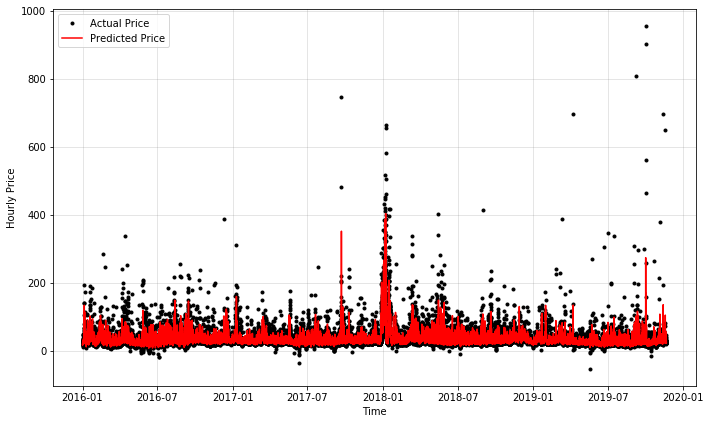

In [120]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig = m_lmp_trans_2.plot(fcst_lmp_trans_2, xlabel='Time', ylabel='Hourly Price', uncertainty=False, ax=ax)
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[0].set_label("Actual Price")
plt.gca().get_lines()[1].set_label("Predicted Price")
plt.legend();
# plt.savefig('img/Predictions.png');
# ax.fill_between(fcst_lmp_trans['ds'], fcst_lmp_trans['yhat_lower'], fcst_lmp_trans['yhat_upper'], color='yellow', alpha=0.5)
# fig = plot_plotly(m_lmp_trans, fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=True)
# py.iplot(fig)

In [121]:
fig = m_lmp_trans_2.plot_components(fcst_lmp_trans_2)

In [122]:
compare_lmp_trans_2 = fcst_lmp_trans_2.set_index('ds')[['yhat',
                                                        'yhat_lower',
                                                        'yhat_upper']].join(df_lmp_trans_2.set_index('ds'))

In [123]:
print_metrics(compare_lmp_trans_2['y'], compare_lmp_trans_2['yhat'])

MSE:  384.61
MAE:  6.61
MAPE:  17.18 %


# Individual Components

In [358]:
# creating list of all possible regressors for use as baseline model
# lmp_base_reg = list(lmp_data.iloc[:, 6:].columns)
eng_sel_reg = ['system_energy_price_da',
               'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
               'sys_energy_congest_da', 'sys_energy_marginal_da', 'sys_energy_da_2', 'HDD', 'CDD', 'humidity']
cong_sel_reg = ['congestion_price_da',
                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                'sys_energy_congest_da', 'marginal_congest_da', 'congestion_da_2', 'HDD', 'CDD', 'humidity']
marg_sel_reg = ['marginal_loss_price_da',
                'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                'sys_energy_marginal_da', 'marginal_congest_da', 'marginal_da_2', 'HDD', 'CDD', 'humidity']

In [359]:
# initializing baseline model
m_lmp_eng = init_prophet_model(eng_sel_reg, model=Prophet(seasonality_prior_scale=0.2))
m_lmp_cong = init_prophet_model(cong_sel_reg, model=Prophet(seasonality_prior_scale=0.2))
m_lmp_marg = init_prophet_model(marg_sel_reg, model=Prophet(seasonality_prior_scale=0.2))

In [360]:
# generating the properly formatted dataframe for use with prophet
# and one for predicting
df_lmp_eng = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', eng_sel_reg)
df_lmp_cong = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', cong_sel_reg)
df_lmp_marg = prophet_df(lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', marg_sel_reg)

In [361]:
# scaling the regressors
# std_scaler_lmp_trans = StandardScaler()
# std_reg_lmp_trans = std_scaler_lmp_trans.fit_transform(df_lmp_trans[lmp_sel_reg])
# df_lmp_trans[lmp_sel_reg] = std_reg_lmp_trans

In [362]:
pred_lmp_eng = df_lmp_eng.drop(columns=['y']).copy()
pred_lmp_cong = df_lmp_cong.drop(columns=['y']).copy()
pred_lmp_marg = df_lmp_marg.drop(columns=['y']).copy()

In [363]:
yj_lmp_eng = PowerTransformer(method='yeo-johnson')
yj_lmp_cong = PowerTransformer(method='yeo-johnson')
yj_lmp_marg = PowerTransformer(method='yeo-johnson')

orig_lmp_y_eng = df_lmp_eng['y'].copy()
pre_trans_lmp_y_eng = np.array(orig_lmp_y_eng).reshape(-1, 1)
transformed_y_eng = yj_lmp_eng.fit_transform(pre_trans_lmp_y_eng)
df_lmp_eng['y'] = transformed_y_eng

orig_lmp_y_cong = df_lmp_cong['y'].copy()
pre_trans_lmp_y_cong = np.array(orig_lmp_y_cong).reshape(-1, 1)
transformed_y_cong = yj_lmp_cong.fit_transform(pre_trans_lmp_y_cong)
df_lmp_cong['y'] = transformed_y_cong

orig_lmp_y_marg = df_lmp_marg['y'].copy()
pre_trans_lmp_y_marg = np.array(orig_lmp_y_marg).reshape(-1, 1)
transformed_y_marg = yj_lmp_marg.fit_transform(pre_trans_lmp_y_marg)
df_lmp_marg['y'] = transformed_y_marg

In [364]:
# fitting the baseline model
m_lmp_eng.fit(df_lmp_eng)
m_lmp_cong.fit(df_lmp_cong)
m_lmp_marg.fit(df_lmp_marg);

In [365]:
fcst_lmp_eng = m_lmp_eng.predict(pred_lmp_eng)
fcst_lmp_cong = m_lmp_cong.predict(pred_lmp_cong)
fcst_lmp_marg = m_lmp_marg.predict(pred_lmp_marg)

In [366]:
# inverse transforming the y's
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_eng[column] = yj_lmp_eng.inverse_transform(np.array(fcst_lmp_eng[column]).reshape(-1, 1))
m_lmp_eng.history['y'] = yj_lmp_eng.inverse_transform(np.array(m_lmp_eng.history['y']).reshape(-1, 1))
df_lmp_eng['y'] = orig_lmp_y_eng

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_cong[column] = yj_lmp_cong.inverse_transform(np.array(fcst_lmp_cong[column]).reshape(-1, 1))
m_lmp_cong.history['y'] = yj_lmp_cong.inverse_transform(np.array(m_lmp_cong.history['y']).reshape(-1, 1))
df_lmp_cong['y'] = orig_lmp_y_cong

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_marg[column] = yj_lmp_marg.inverse_transform(np.array(fcst_lmp_marg[column]).reshape(-1, 1))
m_lmp_marg.history['y'] = yj_lmp_marg.inverse_transform(np.array(m_lmp_marg.history['y']).reshape(-1, 1))
df_lmp_marg['y'] = orig_lmp_y_marg

In [367]:
compare_lmp_eng = fcst_lmp_eng.set_index('ds')[['yhat',
                                                'yhat_lower',
                                                'yhat_upper']].join(df_lmp_eng.set_index('ds'))

compare_lmp_cong = fcst_lmp_cong.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_cong.set_index('ds'))

compare_lmp_marg = fcst_lmp_marg.set_index('ds')[['yhat',
                                                  'yhat_lower',
                                                  'yhat_upper']].join(df_lmp_marg.set_index('ds'))

In [368]:
compare_lmp['y'] = compare_lmp_eng['y'] + compare_lmp_cong['y'] + compare_lmp_marg['y']
compare_lmp['yhat'] = compare_lmp_eng['yhat'] + compare_lmp_cong['yhat'] + compare_lmp_marg['yhat']

In [369]:
print_metrics(compare_lmp['y'], compare_lmp['yhat'])

MSE:  4062.88
MAE:  22.2
MAPE:  20.0 %


In [136]:
# f, ax = plt.subplots(1)
# f.set_figheight(6)
# f.set_figwidth(10)
# fig = m_lmp_trans.plot(fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=False, ax=ax)
# plt.gca().get_lines()[1].set_color("red")
# plt.gca().get_lines()[0].set_label("Actual Price")
# plt.gca().get_lines()[1].set_label("Predicted Price")
# plt.legend();
# plt.savefig('img/Predictions.png');
# ax.fill_between(fcst_lmp_trans['ds'], fcst_lmp_trans['yhat_lower'], fcst_lmp_trans['yhat_upper'], color='yellow', alpha=0.5)
# fig = plot_plotly(m_lmp_trans, fcst_lmp_trans, xlabel='Time', ylabel='Hourly Price', uncertainty=True)
# py.iplot(fig)

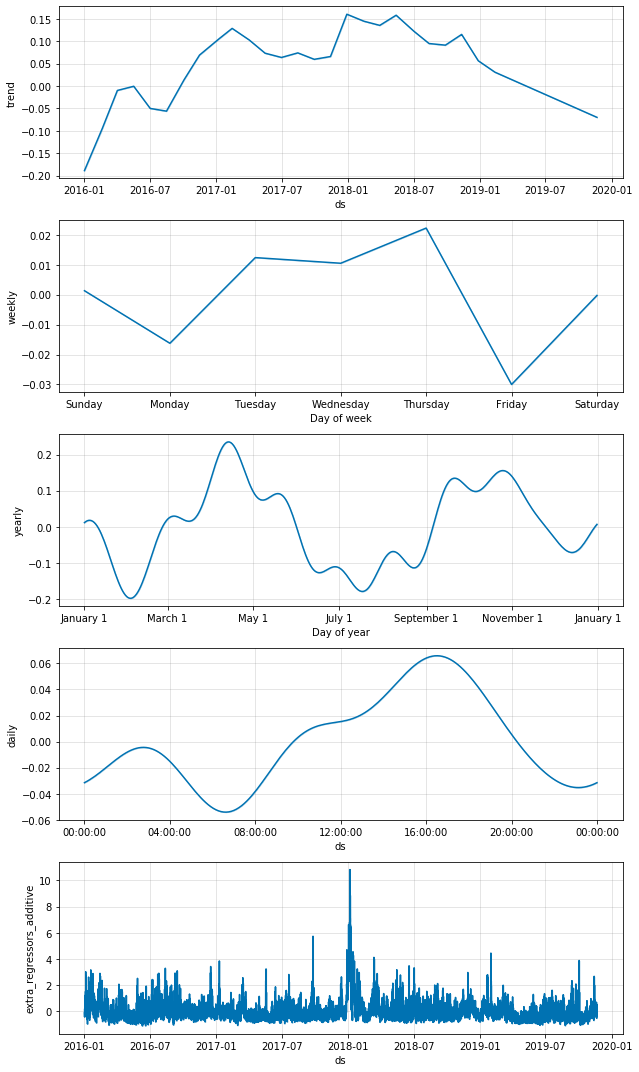

In [83]:
# fig = m_lmp_trans.plot_components(fcst_lmp_trans)

# Looping for feature selection

In [ ]:
['total_lmp_da', 'system_energy_price_da', 'congestion_price_da',
       'marginal_loss_price_da', 'pepco_mw', 'bcpep_flow_mw',
       'bcpep_spread_mw', 'maintenance_outages_mw', 'forced_outages_mw',
       'dewPoint', 'enthalpy', 'apparentTemperature', 'DD', 'CDD', 'HDD',
       'uvIndex', 'peak_hour']

In [137]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
# changepoint_range = [0.8, 0.9, 0.95, 1]
# changepoint_prior_scale = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
# seasonality_prior_scale = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
seasonality_prior_scale = [0.15, 0.2, 0.25]
# creating list of all possible regressors for use as baseline model
# for item in changepoint_range:
#     m_lmp_test = init_prophet_model(core_reg, model=Prophet(changepoint_range=item))

#     df_lmp_test = prophet_df(
#         lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
#     pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

#     yj_lmp = PowerTransformer(method='yeo-johnson')
#     orig_lmp_y = df_lmp_test['y'].copy()
#     pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
#     transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
#     df_lmp_test['y'] = transformed_y

#     m_lmp_test.fit(df_lmp_test)
#     fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

#     for column in ['yhat', 'yhat_lower', 'yhat_upper']:
#         fcst_lmp_test[column] = yj_lmp.inverse_transform(
#             np.array(fcst_lmp_test[column]).reshape(-1, 1))
#     df_lmp_test['y'] = orig_lmp_y
#     compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
#                                                       'yhat_lower',
#                                                       'yhat_upper']].join(df_lmp_test.set_index('ds'))

#     print(test)
#     print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])
    
# for item in changepoint_prior_scale:
#     m_lmp_test = init_prophet_model(core_reg, model=Prophet(changepoint_prior_scale=item))

#     df_lmp_test = prophet_df(
#         lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
#     pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

#     yj_lmp = PowerTransformer(method='yeo-johnson')
#     orig_lmp_y = df_lmp_test['y'].copy()
#     pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
#     transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
#     df_lmp_test['y'] = transformed_y

#     m_lmp_test.fit(df_lmp_test)
#     fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

#     for column in ['yhat', 'yhat_lower', 'yhat_upper']:
#         fcst_lmp_test[column] = yj_lmp.inverse_transform(
#             np.array(fcst_lmp_test[column]).reshape(-1, 1))
#     df_lmp_test['y'] = orig_lmp_y
#     compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
#                                                       'yhat_lower',
#                                                       'yhat_upper']].join(df_lmp_test.set_index('ds'))

#     print(item)
#     print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])
    
for item in seasonality_prior_scale:
    m_lmp_test = init_prophet_model(core_reg, model=Prophet(seasonality_prior_scale=item))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(item)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

0.15
MSE:  444.54
MAE:  7.13
MAPE:  18.83 %
0.2
MSE:  444.72
MAE:  7.13
MAPE:  18.82 %
0.25
MSE:  444.53
MAE:  7.13
MAPE:  18.84 %


In [58]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour']
consider_reg = [[],
                'bcpep_flow_mw',
                'bcpep_spread_mw',
                ['bcpep_flow_mw', 'bcpep_spread_mw'],
                'maintenance_outages_mw',
                'forced_outages_mw',
                ['maintenance_outages_mw', 'forced_outages_mw'],
                'DD',
                'CDD',
                'HDD',
                ['CDD', 'HDD'],
                'uvIndex']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour']
MSE:  445.55
MAE:  7.14
MAPE:  18.87 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw']
MSE:  444.53
MAE:  7.13
MAPE:  18.84 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_spread_mw']
MSE:  445.03
MAE:  7.14
MAPE:  18.86 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  444.58
MAE:  7.13
MAPE:  18.84 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'maintenance_outages_mw']
MSE:  444.65
MAE:  7.15
MAPE:  18.89 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw',

In [59]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = [[],
                'maintenance_outages_mw',
                'forced_outages_mw',
                ['maintenance_outages_mw', 'forced_outages_mw'],
                ['DD'],
                ['CDD'],
                ['HDD'],
                ['CDD', 'HDD'],
                'uvIndex']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  444.58
MAE:  7.13
MAPE:  18.84 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'maintenance_outages_mw']
MSE:  443.52
MAE:  7.13
MAPE:  18.87 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'forced_outages_mw']
MSE:  444.53
MAE:  7.13
MAPE:  18.83 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'maintenance_outages_mw', 'forced_outages_mw']
MSE:  443.59
MAE:  7.13
MAPE:  18.85 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature',

In [63]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = [[],
                'forced_outages_mw',
                'CDD',
                'uvIndex',
                ['DD', 'forced_outages_mw'],
                ['DD', 'CDD'],
                ['DD', 'uvIndex'],
                ['forced_outages_mw', 'CDD'],
                ['forced_outages_mw', 'uvIndex'],
                ['CDD', 'uvIndex'],
                ['forced_outages_mw','CDD', 'uvIndex'],
                ['DD', 'forced_outages_mw', 'CDD'],
                ['DD', 'forced_outages_mw', 'uvIndex'],
                ['DD', 'CDD', 'uvIndex'],
                ['DD', 'forced_outages_mw','CDD', 'uvIndex']]
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  444.58
MAE:  7.13
MAPE:  18.84 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'forced_outages_mw']
MSE:  444.53
MAE:  7.13
MAPE:  18.83 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'CDD']
MSE:  444.43
MAE:  7.13
MAPE:  18.83 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'uvIndex']
MSE:  444.34
MAE:  7.13
MAPE:  18.83 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'DD',

In [21]:
# separately model each component

In [60]:
core_reg = ['system_energy_price_da', 'pepco_mw']
consider_reg = [[],
                'total_lmp_da',
                'congestion_price_da',
                'marginal_loss_price_da',
                ['congestion_price_da', 'marginal_loss_price_da'],
                'bcpep_flow_mw',
                'bcpep_spread_mw',
                ['bcpep_flow_mw', 'bcpep_spread_mw'],
                'maintenance_outages_mw',
                'forced_outages_mw',
                ['maintenance_outages_mw', 'forced_outages_mw'],
                'apparentTemperature',
                'peak_hour',
                'DD',
                'CDD',
                'HDD',
                ['CDD', 'HDD'],
                'uvIndex']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'system_energy_price_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'pepco_mw']
MSE:  245.56
MAE:  5.59
MAPE:  15.86 %
['system_energy_price_da', 'pepco_mw', 'total_lmp_da']
MSE:  243.83
MAE:  5.6
MAPE:  15.92 %
['system_energy_price_da', 'pepco_mw', 'congestion_price_da']
MSE:  243.62
MAE:  5.6
MAPE:  15.93 %
['system_energy_price_da', 'pepco_mw', 'marginal_loss_price_da']
MSE:  245.36
MAE:  5.6
MAPE:  15.88 %
['system_energy_price_da', 'pepco_mw', 'congestion_price_da', 'marginal_loss_price_da']
MSE:  242.99
MAE:  5.61
MAPE:  15.97 %
['system_energy_price_da', 'pepco_mw', 'bcpep_flow_mw']
MSE:  245.3
MAE:  5.59
MAPE:  15.86 %
['system_energy_price_da', 'pepco_mw', 'bcpep_spread_mw']
MSE:  245.43
MAE:  5.59
MAPE:  15.87 %
['system_energy_price_da', 'pepco_mw', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  245.31
MAE:  5.59
MAPE:  15.85 %
['system_energy_price_da', 'pepco_mw', 'maintenance_outages_mw']
MSE:  245.17
MAE:  5.61
MAPE:  15.92 %
['system_energy_price_da', 'pepco_mw', 'forced_outages_mw']
MSE:  245.45
MAE:  5.6
MAPE:  

In [61]:
core_reg = ['congestion_price_da', 'pepco_mw']
consider_reg = [[],
                'total_lmp_da',
                'system_energy_price_da',
                'marginal_loss_price_da',
                ['system_energy_price_da', 'marginal_loss_price_da'],
                'bcpep_flow_mw',
                'bcpep_spread_mw',
                ['bcpep_flow_mw', 'bcpep_spread_mw'],
                'maintenance_outages_mw',
                'forced_outages_mw',
                ['maintenance_outages_mw', 'forced_outages_mw'],
                'apparentTemperature',
                'peak_hour',
                'DD',
                'CDD',
                'HDD',
                ['CDD', 'HDD'],
                'uvIndex']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'congestion_price_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['congestion_price_da', 'pepco_mw']
MSE:  68.33
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'total_lmp_da']
MSE:  68.31
MAE:  2.97
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'system_energy_price_da']
MSE:  68.32
MAE:  2.97
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'marginal_loss_price_da']
MSE:  68.36
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'system_energy_price_da', 'marginal_loss_price_da']
MSE:  68.3
MAE:  2.98
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'bcpep_flow_mw']
MSE:  68.28
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'bcpep_spread_mw']
MSE:  68.29
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  68.28
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'maintenance_outages_mw']
MSE:  68.32
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'forced_outages_mw']
MSE:  68.3
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'maintenance_outages_mw', 'forced_outages_mw']
MSE:  68.28
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'apparentTemperature']
MSE:  68.3
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'peak_hour']
MSE:  68.34
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'DD']
MSE:  68.27
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'CDD']
MSE:  68.33
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'HDD']
MSE:  68.28
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'CDD', 'HDD']
MSE:  68.28
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



['congestion_price_da', 'pepco_mw', 'uvIndex']
MSE:  68.33
MAE:  2.95
MAPE:  inf %


C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [62]:
core_reg = ['marginal_loss_price_da', 'pepco_mw']
consider_reg = [[],
                'total_lmp_da',
                'congestion_price_da',
                'system_energy_price_da',
                ['congestion_price_da', 'system_energy_price_da'],
                'bcpep_flow_mw',
                'bcpep_spread_mw',
                ['bcpep_flow_mw', 'bcpep_spread_mw'],
                'maintenance_outages_mw',
                'forced_outages_mw',
                ['maintenance_outages_mw', 'forced_outages_mw'],
                'apparentTemperature',
                'peak_hour',
                'DD',
                'CDD',
                'HDD',
                ['CDD', 'HDD'],
                'uvIndex']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test)

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'marginal_loss_price_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['marginal_loss_price_da', 'pepco_mw']
MSE:  0.29
MAE:  0.25
MAPE:  777.91 %
['marginal_loss_price_da', 'pepco_mw', 'total_lmp_da']
MSE:  0.29
MAE:  0.25
MAPE:  777.85 %
['marginal_loss_price_da', 'pepco_mw', 'congestion_price_da']
MSE:  0.29
MAE:  0.25
MAPE:  770.34 %
['marginal_loss_price_da', 'pepco_mw', 'system_energy_price_da']
MSE:  0.29
MAE:  0.25
MAPE:  784.6 %
['marginal_loss_price_da', 'pepco_mw', 'congestion_price_da', 'system_energy_price_da']
MSE:  0.28
MAE:  0.25
MAPE:  784.35 %
['marginal_loss_price_da', 'pepco_mw', 'bcpep_flow_mw']
MSE:  0.29
MAE:  0.24
MAPE:  711.0 %
['marginal_loss_price_da', 'pepco_mw', 'bcpep_spread_mw']
MSE:  0.29
MAE:  0.25
MAPE:  689.72 %
['marginal_loss_price_da', 'pepco_mw', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  0.28
MAE:  0.24
MAPE:  701.32 %
['marginal_loss_price_da', 'pepco_mw', 'maintenance_outages_mw']
MSE:  0.28
MAE:  0.25
MAPE:  770.19 %
['marginal_loss_price_da', 'pepco_mw', 'forced_outages_mw']
MSE:  0.29
MAE:  0.25
MAPE:  779.45 %

In [174]:
lmp_data.columns

Index(['datetime_beginning_utc', 'datetime_beginning_ept', 'total_lmp_rt',
       'system_energy_price_rt', 'congestion_price_rt',
       'marginal_loss_price_rt', 'total_lmp_da', 'system_energy_price_da',
       'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw',
       'bcpep_flow_mw', 'bcpep_spread_mw', 'maintenance_outages_mw',
       'forced_outages_mw', 'dewPoint', 'enthalpy', 'apparentTemperature',
       'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour'],
      dtype='object')

In [177]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = [[],
                'pepco_mw_2',
                ['pepco_mw_HDD', 'HDD'],
                ['pepco_mw_CDD', 'CDD'],
                ['pepco_mw_DD', 'DD'],
                'sys_energy_congest_da',
                'sys_energy_da_2',
                'congestion_da_2']
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
MSE:  444.72
MAE:  7.13
MAPE:  18.82 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'pepco_mw_2']
MSE:  443.44
MAE:  7.15
MAPE:  18.87 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'pepco_mw_HDD', 'HDD']
MSE:  444.58
MAE:  7.12
MAPE:  18.83 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'pepco_mw_CDD', 'CDD']
MSE:  443.58
MAE:  7.14
MAPE:  18.85 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bc

In [ ]:
lmp_data[]

In [180]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = ['marginal_da_2',
                ['sys_energy_congest_da', 'sys_energy_da_2'],
                ['sys_energy_congest_da', 'congestion_da_2'],
                ['sys_energy_da_2', 'congestion_da_2'],
                ['sys_energy_congest_da', 'sys_energy_da_2', 'congestion_da_2']]
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'marginal_da_2']
MSE:  438.12
MAE:  7.08
MAPE:  18.67 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_da_2']
MSE:  431.16
MAE:  7.04
MAPE:  18.45 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'congestion_da_2']
MSE:  439.15
MAE:  7.1
MAPE:  18.7 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_da_2', 'congestion_da_2']
MSE:  432.15
MAE:  7.04
MAPE:  18.46 %
['system_energy_price_da', 'congestion_price_da', 'marginal_los

In [182]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = ['sys_energy_marginal_da',
                'marginal_congest_da',
                'sys_energy_da_2',
                ['sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2']]
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_marginal_da']
MSE:  435.17
MAE:  7.07
MAPE:  18.59 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'marginal_congest_da']
MSE:  440.07
MAE:  7.1
MAPE:  18.72 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_da_2']
MSE:  432.33
MAE:  7.05
MAPE:  18.49 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2']
MSE:  430.0
MAE:  7.05
MAPE:  18.44 %


In [183]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw']
consider_reg = [['sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'DD'],
                ['sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD'],
                ['sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'CDD'],
                ['sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD']]
reg_tests = [core_reg + [x] if (type(x) is str) else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'DD']
MSE:  430.07
MAE:  7.05
MAPE:  18.44 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD']
MSE:  430.02
MAE:  7.05
MAPE:  18.44 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'CDD']
MSE:  429.9
MAE:  7.05
MAPE:  18.45

In [325]:
lmp_data.columns

Index(['datetime_beginning_utc', 'datetime_beginning_ept', 'total_lmp_rt',
       'system_energy_price_rt', 'congestion_price_rt',
       'marginal_loss_price_rt', 'total_lmp_da', 'system_energy_price_da',
       'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw',
       'apsouth_flow_mw', 'apsouth_spread_mw', 'bcpep_flow_mw',
       'bcpep_spread_mw', 'bed_bla_flow_mw', 'bed_bla_spread_mw',
       'central_flow_mw', 'central_spread_mw', 'east_flow_mw',
       'east_spread_mw', 'west_flow_mw', 'west_spread_mw',
       'maintenance_outages_mw', 'forced_outages_mw', 'dewPoint', 'enthalpy',
       'apparentTemperature', 'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour',
       'pepco_mw_2', 'pepco_mw_HDD', 'pepco_mw_CDD', 'pepco_mw_DD',
       'sys_energy_congest_da', 'sys_energy_marginal_da',
       'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2',
       'marginal_da_2'],
      dtype='object')

In [343]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
            'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
            'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD']
consider_reg = [['humidity'],
                ['humidity_ratio'],
                ['humidity', 'humidity_ratio']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
MSE:  429.89
MAE:  7.04
MAPE:  18.42 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity_ratio']
MSE:  430.0
MAE:  7.05
MAPE:  18.45 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2'

In [340]:
core_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
            'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
            'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
            'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD']
consider_reg = [['apsouth_flow_mw', 'apsouth_spread_mw'],
                ['bed_bla_flow_mw', 'bed_bla_spread_mw'],
                ['central_flow_mw', 'central_spread_mw'],
                ['east_flow_mw', 'east_spread_mw'],
                ['west_flow_mw', 'west_spread_mw'],
                ['apsouth_flow_mw', 'apsouth_spread_mw',
                 'bed_bla_flow_mw', 'bed_bla_spread_mw',
                 'central_flow_mw', 'central_spread_mw',
                 'east_flow_mw', 'east_spread_mw',
                 'west_flow_mw', 'west_spread_mw']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'apsouth_flow_mw', 'apsouth_spread_mw']
MSE:  429.89
MAE:  7.06
MAPE:  18.46 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'bed_bla_flow_mw', 'bed_bla_spread_mw']
MSE:  429.79
MAE:  7.05
MAPE:  18.44 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 's

In [14]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
consider_reg = [['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'],
                ['system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4', 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5', 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24']
MSE:  359.19
MAE:  6.33
MAPE:  

In [19]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
consider_reg = [['system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'],
                ['system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'],
                ['system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5',
                 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27']]
reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4', 'system_energy_price_rt_lag_5', 'congestion_price_rt_lag_5', 'marginal_loss_price_rt_lag_5', 'system_energy_price_rt_lag_6', 'congestion_price_rt_lag_6', 'marginal_loss_price_rt_lag_6', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24']
MSE:  396.82
MAE:  6.72
MAPE:  17.58 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw

In [21]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']
consider_reg = [['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25'],
                ['system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26'],
                ['system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1']]

reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24', 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25', 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26']
MSE:  360.05
MAE:  6.32
MAPE:  16.38 %
['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pe

In [66]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']

consider_reg = [['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_da_lag_3', 'sys_energy_marginal_da_lag_3','marginal_congest_da_lag_3',
                 'sys_energy_da_2_lag_3', 'congestion_da_2_lag_3', 'marginal_da_2_lag_3',
                 'sys_energy_congest_da_lag_4', 'sys_energy_marginal_da_lag_4', 'marginal_congest_da_lag_4',
                 'sys_energy_da_2_lag_4', 'congestion_da_2_lag_4', 'marginal_da_2_lag_4',
                 'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                 'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                 'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                 'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                 'sys_energy_congest_da_lag_26', 'sys_energy_marginal_da_lag_26', 'marginal_congest_da_lag_26',
                 'sys_energy_da_2_lag_26', 'congestion_da_2_lag_26', 'marginal_da_2_lag_26',
                 'sys_energy_congest_da_lag_27', 'sys_energy_marginal_da_lag_27', 'marginal_congest_da_lag_27',
                 'sys_energy_da_2_lag_27', 'congestion_da_2_lag_27', 'marginal_da_2_lag_27'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25']]

reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24', 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25', 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26', 'system_energy_price_rt_l

In [74]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity']

consider_reg = [['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25'],
                ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_da_lag_3', 'sys_energy_marginal_da_lag_3','marginal_congest_da_lag_3',
                 'sys_energy_da_2_lag_3', 'congestion_da_2_lag_3', 'marginal_da_2_lag_3',
                 'sys_energy_congest_da_lag_4', 'sys_energy_marginal_da_lag_4', 'marginal_congest_da_lag_4',
                 'sys_energy_da_2_lag_4', 'congestion_da_2_lag_4', 'marginal_da_2_lag_4',
                 'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                 'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                 'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                 'sys_energy_da_2_lag_25', 'congestion_da_2_lag_25', 'marginal_da_2_lag_25',
                 'sys_energy_congest_da_lag_26', 'sys_energy_marginal_da_lag_26', 'marginal_congest_da_lag_26',
                 'sys_energy_da_2_lag_26', 'congestion_da_2_lag_26', 'marginal_da_2_lag_26',
                 'sys_energy_congest_da_lag_27', 'sys_energy_marginal_da_lag_27', 'marginal_congest_da_lag_27',
                 'sys_energy_da_2_lag_27', 'congestion_da_2_lag_27', 'marginal_da_2_lag_27',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25'],
               ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                 'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                 'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25'],
               ['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25']]

reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24', 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25', 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26', 'system_energy_price_rt_l

KeyboardInterrupt: 

In [75]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity'

consider_reg = [['system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                 'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                 'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                 'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                 'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                 'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                 'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                 'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                 'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                 'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                 'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                 'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                 'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                 'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25']]

reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw', 'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da', 'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity', 'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1', 'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2', 'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3', 'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4', 'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24', 'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25', 'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26', 'system_energy_price_rt_l

In [ ]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                          'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                          'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                          'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                          'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                          'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                          'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                          'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                          'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                          'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                          'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                          'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                          'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                          'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                          'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                          'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                          'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                          'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                          'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                          'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                          'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                          'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                          'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                          'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25']

consider_reg = ['system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']


reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

In [ ]:
core_reg = lmp_sel_reg = ['system_energy_price_da', 'congestion_price_da', 'marginal_loss_price_da',
                          'pepco_mw', 'apparentTemperature', 'peak_hour', 'bcpep_flow_mw', 'bcpep_spread_mw',
                          'sys_energy_congest_da', 'sys_energy_marginal_da', 'marginal_congest_da',
                          'sys_energy_da_2', 'congestion_da_2', 'marginal_da_2', 'HDD', 'CDD', 'humidity',
                          'system_energy_price_rt_lag_1', 'congestion_price_rt_lag_1', 'marginal_loss_price_rt_lag_1',
                          'system_energy_price_rt_lag_2', 'congestion_price_rt_lag_2', 'marginal_loss_price_rt_lag_2',
                          'system_energy_price_rt_lag_3', 'congestion_price_rt_lag_3', 'marginal_loss_price_rt_lag_3',
                          'system_energy_price_rt_lag_4', 'congestion_price_rt_lag_4', 'marginal_loss_price_rt_lag_4',
                          'system_energy_price_rt_lag_24', 'congestion_price_rt_lag_24', 'marginal_loss_price_rt_lag_24',
                          'system_energy_price_rt_lag_25', 'congestion_price_rt_lag_25', 'marginal_loss_price_rt_lag_25',
                          'system_energy_price_rt_lag_26', 'congestion_price_rt_lag_26', 'marginal_loss_price_rt_lag_26',
                          'system_energy_price_rt_lag_27', 'congestion_price_rt_lag_27', 'marginal_loss_price_rt_lag_27',
                          'sys_energy_congest_da_lag_1', 'sys_energy_marginal_da_lag_1', 'marginal_congest_da_lag_1',
                          'sys_energy_da_2_lag_1', 'congestion_da_2_lag_1', 'marginal_da_2_lag_1',
                          'sys_energy_congest_da_lag_2', 'sys_energy_marginal_da_lag_2', 'marginal_congest_da_lag_2',
                          'sys_energy_da_2_lag_2', 'congestion_da_2_lag_2', 'marginal_da_2_lag_2',
                          'sys_energy_congest_da_lag_24', 'sys_energy_marginal_da_lag_24', 'marginal_congest_da_lag_24',
                          'sys_energy_da_2_lag_24', 'congestion_da_2_lag_24', 'marginal_da_2_lag_24',
                          'sys_energy_congest_da_lag_25', 'sys_energy_marginal_da_lag_25', 'marginal_congest_da_lag_25',
                          'sys_energy_congest_rt_lag_1', 'sys_energy_marginal_rt_lag_1', 'marginal_congest_rt_lag_1',
                          'sys_energy_rt_2_lag_1', 'congestion_rt_2_lag_1', 'marginal_rt_2_lag_1',
                          'sys_energy_congest_rt_lag_2', 'sys_energy_marginal_rt_lag_2', 'marginal_congest_rt_lag_2',
                          'sys_energy_rt_2_lag_2', 'congestion_rt_2_lag_2', 'marginal_rt_2_lag_2',
                          'sys_energy_congest_rt_lag_24', 'sys_energy_marginal_rt_lag_24', 'marginal_congest_rt_lag_24',
                          'sys_energy_rt_2_lag_24', 'congestion_rt_2_lag_24', 'marginal_rt_2_lag_24',
                          'sys_energy_congest_rt_lag_25', 'sys_energy_marginal_rt_lag_25', 'marginal_congest_rt_lag_25',
                          'sys_energy_rt_2_lag_25', 'congestion_rt_2_lag_25', 'marginal_rt_2_lag_25',
                         'system_energy_price_da_lag_1', 'congestion_price_da_lag_1', 'marginal_loss_price_da_lag_1',
                'system_energy_price_da_lag_2', 'congestion_price_da_lag_2', 'marginal_loss_price_da_lag_2',
                'system_energy_price_da_lag_24', 'congestion_price_da_lag_24', 'marginal_loss_price_da_lag_24',
                'system_energy_price_da_lag_25', 'congestion_price_da_lag_25', 'marginal_loss_price_da_lag_25']

consider_reg = [['pepco_mw_lag_1',
                  'bcpep_flow_mw_lag_1',
                  'bcpep_spread_mw_lag_1',
                  'pepco_mw_lag_2',
                  'bcpep_flow_mw_lag_2',
                  'bcpep_spread_mw_lag_2',
                  'pepco_mw_lag_3',
                  'bcpep_flow_mw_lag_3',
                  'bcpep_spread_mw_lag_3',
                  'pepco_mw_lag_4',
                  'bcpep_flow_mw_lag_4',
                  'bcpep_spread_mw_lag_4',
                  'pepco_mw_lag_5',
                  'bcpep_flow_mw_lag_5',
                  'bcpep_spread_mw_lag_5',
                  'pepco_mw_lag_6',
                  'bcpep_flow_mw_lag_6',
                  'bcpep_spread_mw_lag_6',
                  'pepco_mw_lag_24',
                  'bcpep_flow_mw_lag_24',
                  'bcpep_spread_mw_lag_24',
                  'pepco_mw_lag_25',
                  'bcpep_flow_mw_lag_25',
                  'bcpep_spread_mw_lag_25',
                  'pepco_mw_lag_26',
                  'bcpep_flow_mw_lag_26',
                  'bcpep_spread_mw_lag_26',
                  'pepco_mw_lag_27',
                  'bcpep_flow_mw_lag_27',
                  'bcpep_spread_mw_lag_27'],
                ['pepco_mw_lag_1',
                  'bcpep_flow_mw_lag_1',
                  'bcpep_spread_mw_lag_1',
                  'pepco_mw_lag_2',
                  'bcpep_flow_mw_lag_2',
                  'bcpep_spread_mw_lag_2',
                  'pepco_mw_lag_3',
                  'bcpep_flow_mw_lag_3',
                  'bcpep_spread_mw_lag_3',
                  'pepco_mw_lag_4',
                  'bcpep_flow_mw_lag_4',
                  'bcpep_spread_mw_lag_4',
                  'pepco_mw_lag_24',
                  'bcpep_flow_mw_lag_24',
                  'bcpep_spread_mw_lag_24',
                  'pepco_mw_lag_25',
                  'bcpep_flow_mw_lag_25',
                  'bcpep_spread_mw_lag_25',
                  'pepco_mw_lag_26',
                  'bcpep_flow_mw_lag_26',
                  'bcpep_spread_mw_lag_26',
                  'pepco_mw_lag_27',
                  'bcpep_flow_mw_lag_27',
                  'bcpep_spread_mw_lag_27'],
                ['pepco_mw_lag_1',
                  'pepco_mw_lag_2',
                  'pepco_mw_lag_3',
                  'pepco_mw_lag_4',
                  'pepco_mw_lag_5',
                  'pepco_mw_lag_6',
                  'pepco_mw_lag_24',
                  'pepco_mw_lag_25',
                  'pepco_mw_lag_26',
                  'pepco_mw_lag_27'],
               ['pepco_mw_lag_1',
                  'pepco_mw_lag_2',
                  'pepco_mw_lag_3',
                  'pepco_mw_lag_4',
                  'pepco_mw_lag_24',
                  'pepco_mw_lag_25',
                  'pepco_mw_lag_26',
                  'pepco_mw_lag_27'],
               ['pepco_mw_lag_1',
                  'bcpep_flow_mw_lag_1',
                  'bcpep_spread_mw_lag_1',
                  'pepco_mw_lag_2',
                  'bcpep_flow_mw_lag_2',
                  'bcpep_spread_mw_lag_2',
                  'pepco_mw_lag_24',
                  'bcpep_flow_mw_lag_24',
                  'bcpep_spread_mw_lag_24',
                  'pepco_mw_lag_25',
                  'bcpep_flow_mw_lag_25',
                  'bcpep_spread_mw_lag_25'],
                ['pepco_mw_lag_1',
                  'pepco_mw_lag_2',
                  'pepco_mw_lag_24',
                  'pepco_mw_lag_25']]


reg_tests = [core_reg + [x] if (type(x) is str)
             else core_reg + x for x in consider_reg]
# creating list of all possible regressors for use as baseline model
for test in reg_tests:
    m_lmp_test = init_prophet_model(
        test, model=Prophet(seasonality_prior_scale=0.2))

    df_lmp_test = prophet_df(
        lmp_data, 'datetime_beginning_ept', 'total_lmp_rt', test)
    pred_lmp_test = df_lmp_test.drop(columns=['y']).copy()

    yj_lmp = PowerTransformer(method='yeo-johnson')
    orig_lmp_y = df_lmp_test['y'].copy()
    pre_trans_lmp_y = np.array(orig_lmp_y).reshape(-1, 1)
    transformed_y = yj_lmp.fit_transform(pre_trans_lmp_y)
    df_lmp_test['y'] = transformed_y

    m_lmp_test.fit(df_lmp_test)
    fcst_lmp_test = m_lmp_test.predict(pred_lmp_test)

    for column in ['yhat', 'yhat_lower', 'yhat_upper']:
        fcst_lmp_test[column] = yj_lmp.inverse_transform(
            np.array(fcst_lmp_test[column]).reshape(-1, 1))
    df_lmp_test['y'] = orig_lmp_y
    compare_lmp_test = fcst_lmp_test.set_index('ds')[['yhat',
                                                      'yhat_lower',
                                                      'yhat_upper']].join(df_lmp_test.set_index('ds'))

    print(test)
    print_metrics(compare_lmp_test['y'], compare_lmp_test['yhat'])

In [23]:
# now cross validating

In [371]:
lmp_trans_cv = cross_validation(m_lmp_trans, initial='26285 hours', period='25 hours', horizon = '4 hours')

INFO:fbprophet:Making 311 forecasts with cutoffs between 2019-01-01 21:00:00 and 2019-11-20 19:00:00


In [372]:
lmp_trans_p = performance_metrics(lmp_trans_cv)
lmp_trans_p.head()

horizon         mse       rmse       mae      mape  coverage
0 01:00:00  468.064506  21.634798  6.822104  0.181317  0.967846
1 02:00:00  280.504128  16.748257  6.343981  0.190856  0.974277
2 03:00:00  233.236264  15.272075  5.796996  0.177826  0.977492
3 04:00:00  261.590207  16.173751  6.236919  0.180465  0.967846

In [375]:
lmp_trans_p.describe()

horizon         mse       rmse       mae      mape  \
count                       4    4.000000   4.000000  4.000000  4.000000   
mean          0 days 02:30:00  310.848776  17.457220  6.300000  0.182616   
std    0 days 01:17:27.580015  106.595328   2.850552  0.420919  0.005691   
min           0 days 01:00:00  233.236264  15.272075  5.796996  0.177826   
25%           0 days 01:45:00  254.501721  15.948332  6.126938  0.179806   
50%           0 days 02:30:00  271.047168  16.461004  6.290450  0.180891   
75%           0 days 03:15:00  327.394223  17.969893  6.463512  0.183702   
max           0 days 04:00:00  468.064506  21.634798  6.822104  0.190856   

       coverage  
count  4.000000  
mean   0.971865  
std    0.004823  
min    0.967846  
25%    0.967846  
50%    0.971061  
75%    0.975080  
max    0.977492

In [373]:
lmp_trans_cv.head()

ds       yhat  yhat_lower  yhat_upper          y  \
0 2019-01-01 22:00:00  24.886592    1.741708   49.739904  23.861894   
1 2019-01-01 23:00:00  23.672376   -0.156495   47.465476  19.324686   
2 2019-01-02 00:00:00  24.221871   -0.120493   49.185462  21.401638   
3 2019-01-02 01:00:00  24.159448    0.517412   48.729456  21.183081   
4 2019-01-02 23:00:00  25.942882    0.062413   49.880614  22.460105   

               cutoff  
0 2019-01-01 21:00:00  
1 2019-01-01 21:00:00  
2 2019-01-01 21:00:00  
3 2019-01-01 21:00:00  
4 2019-01-02 22:00:00

In [374]:
fig = plot_cross_validation_metric(lmp_trans_cv, metric='mape')